In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [2]:
import pandas as pd
import numpy as np
import keras
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping

import sklearn.metrics as metrics
from keras.callbacks import LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
import os
import pandas as pd

healthy_dirs = [
    r'/kaggle/input/osteoporosis-database/Osteoporosis Knee X-ray/normal',
    r'/kaggle/input/osteoporosis-knee-xray-dataset/normal/normal',
    r'/kaggle/input/osteoporosis-knee-dataset-preprocessed128x256/Osteoporosis Knee Dataset/Normal',
    r'/kaggle/input/osteoporosis/osteoporosis/normal'
]


osteoporosis_dirs = [
    r'/kaggle/input/osteoporosis-database/Osteoporosis Knee X-ray/osteoporosis',
    r'/kaggle/input/osteoporosis-knee-xray-dataset/osteoporosis/osteoporosis',
    r'/kaggle/input/osteoporosis-knee-dataset-preprocessed128x256/Osteoporosis Knee Dataset/Osteoporosis',
    r'/kaggle/input/osteoporosis/osteoporosis/osteoporosis'
]

filepaths = []
labels = []
dict_lists = [healthy_dirs, osteoporosis_dirs]
class_labels = ['Healthy', 'Osteoporosis']

for i, dir_list in enumerate(dict_lists):
    for j in dir_list:
        flist = os.listdir(j)
        for f in flist:
            fpath = os.path.join(j, f)
            filepaths.append(fpath)
            labels.append(class_labels[i])

Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
knee_osteoporosis_data = pd.concat([Fseries, Lseries], axis=1)
knee_osteoporosis_df = pd.DataFrame(knee_osteoporosis_data)
print(knee_osteoporosis_df.head())
print(knee_osteoporosis_df["labels"].value_counts())


                                           filepaths   labels
0  /kaggle/input/osteoporosis-database/Osteoporos...  Healthy
1  /kaggle/input/osteoporosis-database/Osteoporos...  Healthy
2  /kaggle/input/osteoporosis-database/Osteoporos...  Healthy
3  /kaggle/input/osteoporosis-database/Osteoporos...  Healthy
4  /kaggle/input/osteoporosis-database/Osteoporos...  Healthy
labels
Osteoporosis    793
Healthy         780
Name: count, dtype: int64


In [4]:
knee_osteoporosis_df.shape

(1573, 2)

In [5]:
train_images, test_images = train_test_split(knee_osteoporosis_df, test_size=0.3, random_state=42)
train_set, val_set = train_test_split(knee_osteoporosis_df, test_size=0.2, random_state=42)

In [6]:
print(train_set.shape)
print(test_images.shape)
print(val_set.shape)
print(train_images.shape)

(1258, 2)
(472, 2)
(315, 2)
(1101, 2)


In [7]:
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(dataframe= train_set,x_col="filepaths",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical", #used for Sequential Model
                                      batch_size=4,
                                      shuffle=False            #do not shuffle data
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_images,x_col="filepaths", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=4,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="filepaths", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=4,
                                    shuffle=False
                                   )

Found 1258 validated image filenames belonging to 2 classes.
Found 472 validated image filenames belonging to 2 classes.
Found 315 validated image filenames belonging to 2 classes.


In [8]:
classes=list(train.class_indices.keys())
print (classes)

['Healthy', 'Osteoporosis']


In [9]:
def show_knee_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen) # get a sample batch from the generator
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2 #scale images between 0 and 1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()

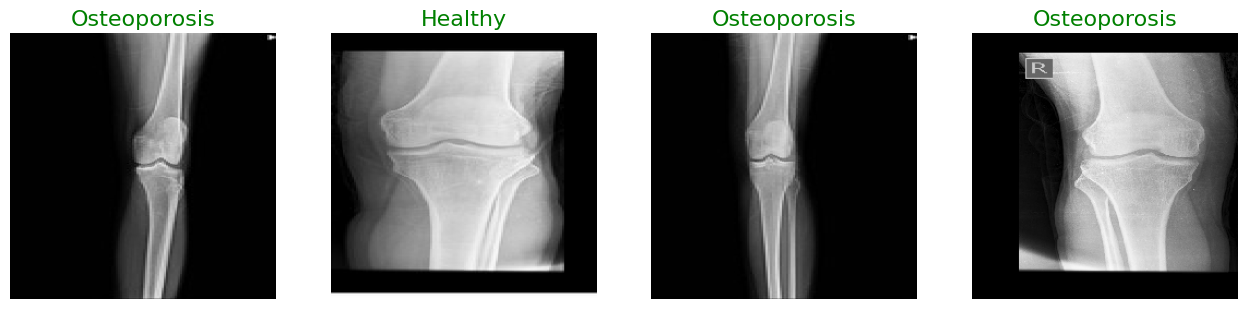

In [10]:
show_knee_images(train)

In [11]:
# FLOAT16 for faster GPU training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

from keras.layers import Flatten, Dense
from keras.models import Model
from keras.applications.vgg19 import VGG19
import tensorflow as tf

# Path to your weight file (must be the .h5 file)
local_weights = "/kaggle/input/vgg19-weeights/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5"

# Load VGG19 with local weights
vgg19_model = VGG19(
    weights=local_weights,
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze VGG19 layers (huge speed boost)
for layer in vgg19_model.layers:
    layer.trainable = False

# Custom head (optimized for speed)
x = vgg19_model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dense(512, activation="relu")(x)

# Final layer (must be float32 when using mixed_precision)
output = Dense(2, activation="sigmoid", dtype='float32')(x)

# Build the model
model = Model(inputs=vgg19_model.input, outputs=output)

# Compile with fast optimizer
model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [12]:
history = model.fit(train, epochs=10, validation_data=val, verbose=1)

Epoch 1/10
315/315 [==============================] - 38s 111ms/step - loss: nan - accuracy: 0.5056 - val_loss: nan - val_accuracy: 0.5460
Epoch 2/10
315/315 [==============================] - 20s 63ms/step - loss: nan - accuracy: 0.5072 - val_loss: nan - val_accuracy: 0.5460
Epoch 3/10
315/315 [==============================] - 19s 62ms/step - loss: nan - accuracy: 0.5072 - val_loss: nan - val_accuracy: 0.5460
Epoch 4/10
315/315 [==============================] - 19s 62ms/step - loss: nan - accuracy: 0.5072 - val_loss: nan - val_accuracy: 0.5460
Epoch 5/10
315/315 [==============================] - 20s 62ms/step - loss: nan - accuracy: 0.5072 - val_loss: nan - val_accuracy: 0.5460
Epoch 6/10
315/315 [==============================] - 20s 62ms/step - loss: nan - accuracy: 0.5072 - val_loss: nan - val_accuracy: 0.5460
Epoch 7/10
315/315 [==============================] - 19s 61ms/step - loss: nan - accuracy: 0.5072 - val_loss: nan - val_accuracy: 0.5460
Epoch 8/10
315/315 [=============

In [13]:
history1 = model.fit(train, epochs=11, validation_data=val, verbose=1)

Epoch 1/11
315/315 [==============================] - 20s 62ms/step - loss: nan - accuracy: 0.5072 - val_loss: nan - val_accuracy: 0.5460
Epoch 2/11
315/315 [==============================] - 20s 62ms/step - loss: nan - accuracy: 0.5072 - val_loss: nan - val_accuracy: 0.5460
Epoch 3/11
315/315 [==============================] - 19s 61ms/step - loss: nan - accuracy: 0.5072 - val_loss: nan - val_accuracy: 0.5460
Epoch 4/11
315/315 [==============================] - 20s 62ms/step - loss: nan - accuracy: 0.5072 - val_loss: nan - val_accuracy: 0.5460
Epoch 5/11
315/315 [==============================] - 19s 62ms/step - loss: nan - accuracy: 0.5072 - val_loss: nan - val_accuracy: 0.5460
Epoch 6/11
315/315 [==============================] - 19s 61ms/step - loss: nan - accuracy: 0.5072 - val_loss: nan - val_accuracy: 0.5460
Epoch 7/11
315/315 [==============================] - 20s 62ms/step - loss: nan - accuracy: 0.5072 - val_loss: nan - val_accuracy: 0.5460
Epoch 8/11
315/315 [==============

In [14]:
model.evaluate(test, verbose=1)

118/118 [==============================] - 6s 48ms/step - loss: nan - accuracy: 0.5085


[nan, 0.508474588394165]

In [15]:
history2 = model.fit(train, epochs=8, validation_data=val, verbose=1)

Epoch 1/8
315/315 [==============================] - 19s 62ms/step - loss: nan - accuracy: 0.5072 - val_loss: nan - val_accuracy: 0.5460
Epoch 2/8
315/315 [==============================] - 19s 62ms/step - loss: nan - accuracy: 0.5072 - val_loss: nan - val_accuracy: 0.5460
Epoch 3/8
315/315 [==============================] - 20s 63ms/step - loss: nan - accuracy: 0.5072 - val_loss: nan - val_accuracy: 0.5460
Epoch 4/8
315/315 [==============================] - 20s 62ms/step - loss: nan - accuracy: 0.5072 - val_loss: nan - val_accuracy: 0.5460
Epoch 5/8
 35/315 [==>...........................] - ETA: 12s - loss: nan - accuracy: 0.5000


KeyboardInterrupt



In [ ]:
model.evaluate(test, verbose=1)

In [ ]:
history3 = model.fit(train, epochs=5, validation_data=val, verbose=1)

In [ ]:
model.evaluate(test, verbose=1)

In [ ]:
history4 = model.fit(train, epochs=9, validation_data=val, verbose=1)

In [ ]:
model.evaluate(test, verbose=1)

In [ ]:
history5 = model.fit(train, epochs=12, validation_data=val, verbose=1)

In [ ]:
model.evaluate(test, verbose=1)

In [ ]:
history6 = model.fit(train, epochs=15, validation_data=val, verbose=1)

In [ ]:
model.evaluate(test, verbose=1)

In [ ]:
history7 = model.fit(train, epochs=20, validation_data=val, verbose=1)

In [ ]:
model.evaluate(test, verbose=1)

In [ ]:
history8 = model.fit(train, epochs=5, validation_data=val, verbose=1)

In [ ]:
model.evaluate(test, verbose=1)

In [ ]:
model.save("osteoporosisEEEEEEEEEEEEEEbinary-9513-01813.h5")

In [ ]:
history8 = model.fit(train, epochs=5, validation_data=val, verbose=1)

In [ ]:
model.evaluate(test, verbose=1)

In [ ]:
history9 = model.fit(train, epochs=5, validation_data=val, verbose=1)

In [ ]:
model.evaluate(test, verbose=1)

In [ ]:
model.save("osteoporosisEEEEEEEEEEEEEEbinary-9406-01328.h5")

In [ ]:
history10 = model.fit(train, epochs=5, validation_data=val, verbose=1)

In [ ]:
model.evaluate(test, verbose=1)

In [ ]:
model.save("osteoporosisEEEEEEEEEEEEEEbinary-9406-01093.h5")

In [ ]:
history11 = model.fit(train, epochs=5, validation_data=val, verbose=1)

In [ ]:
model.evaluate(test, verbose=1)

In [ ]:
model.save("osteoporosisEEEEEEEEEEEEEEbinary-9510-01134.h5")

In [ ]:
history12 = model.fit(train, epochs=5, validation_data=val, verbose=1)

In [ ]:
model.evaluate(test, verbose=1)

In [ ]:
history12 = model.fit(train, epochs=5, validation_data=val, verbose=1)

In [ ]:
model.evaluate(test, verbose=1)

In [ ]:
history13 = model.fit(train, epochs=5, validation_data=val, verbose=1)

In [ ]:
model.evaluate(test, verbose=1)

In [ ]:
model.save("osteoporosisEEEEEEEEEEEEEEbinary-9533-01016.h5")

In [ ]:
history14 = model.fit(train, epochs=5, validation_data=val, verbose=1)

In [ ]:
model.evaluate(test, verbose=1)

In [ ]:
history15 = model.fit(train, epochs=5, validation_data=val, verbose=1)

In [ ]:
model.evaluate(test, verbose=1)

In [ ]:
history16 = model.fit(train, epochs=5, validation_data=val, verbose=1)

In [ ]:
model.evaluate(test, verbose=1)

In [ ]:
history17 = model.fit(train, epochs=5, validation_data=val, verbose=1)

In [ ]:
model.evaluate(test, verbose=1)

In [ ]:
model.save("osteoporosisEEEEEEEEEEEEEEbinary-9533-00959.h5")

In [ ]:
history18 = model.fit(train, epochs=5, validation_data=val, verbose=1)

In [ ]:
model.evaluate(test, verbose=1)

In [ ]:
model.save("osteoporosisEEEEEEEEEEEEEEbinary-9597-00927.h5")

In [ ]:
history19 = model.fit(train, epochs=5, validation_data=val, verbose=1)

In [ ]:
model.evaluate(test, verbose=1)

In [ ]:
history20 = model.fit(train, epochs=5, validation_data=val, verbose=1)

In [ ]:
model.evaluate(test, verbose=1)

In [ ]:
history21 = model.fit(train, epochs=5, validation_data=val, verbose=1)

In [ ]:
model.evaluate(test, verbose=1)

In [ ]:
history22 = model.fit(train, epochs=5, validation_data=val, verbose=1)

In [ ]:
model.evaluate(test, verbose=1)

In [ ]:
model.save("osteoporosisEEEEEEEEEEEEEEbinary-9618-0854.h5")

In [ ]:
history23 = model.fit(train, epochs=5, validation_data=val, verbose=1)

In [ ]:
model.evaluate(test, verbose=1)

In [ ]:
history24 = model.fit(train, epochs=5, validation_data=val, verbose=1)

In [ ]:
model.evaluate(test, verbose=1)

In [ ]:
history25 = model.fit(train, epochs=5, validation_data=val, verbose=1)

In [ ]:
model.evaluate(test, verbose=1)

In [ ]:
history26 = model.fit(train, epochs=5, validation_data=val, verbose=1)

In [ ]:
history27 = model.fit(train, epochs=5, validation_data=val, verbose=1)

In [ ]:
model.evaluate(test, verbose=1)

In [ ]:
history28 = model.fit(train, epochs=5, validation_data=val, verbose=1)

In [ ]:
model.evaluate(test, verbose=1)

In [ ]:
history29 = model.fit(train, epochs=5, validation_data=val, verbose=1)

In [ ]:
model.evaluate(test, verbose=1)

In [ ]:
model.save("osteoporosisEEEEEEEEEEEEEEbinary-9682-00660.h5")

In [ ]:
history30 = model.fit(train, epochs=5, validation_data=val, verbose=1)

In [ ]:
model.evaluate(test, verbose=1)

In [ ]:
history31 = model.fit(train, epochs=5, validation_data=val, verbose=1)

In [ ]:
model.evaluate(test, verbose=1)

In [ ]:
history32 = model.fit(train, epochs=5, validation_data=val, verbose=1)

In [ ]:
history33 = model.fit(train, epochs=5, validation_data=val, verbose=1)

In [ ]:
model.evaluate(test, verbose=1)

In [ ]:
model.save("osteoporosisEEEEEEEEEEEEEEbinary-9745-00681.h5")

In [ ]:
pred = model.predict(test)
pred = np.argmax(pred, axis=1) #pick class with highest  probability

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

In [16]:
from sklearn.metrics import confusion_matrix, accuracy_score

y_test = test_images.labels # set y_test to the expected output
print(classification_report(y_test, pred2))
print("Accuracy of the Model:","{:.1f}%".format(accuracy_score(y_test, pred2)*100))

NameError: name 'pred2' is not defined

In [ ]:
plt.plot(history.history["accuracy"] +
history1.history["accuracy"] +
history2.history["accuracy"] +
history3.history["accuracy"] +
history4.history["accuracy"] +
history5.history["accuracy"] +
history6.history["accuracy"] +
history7.history["accuracy"] +
history8.history["accuracy"] +
history9.history["accuracy"] +
history10.history["accuracy"] +
history11.history["accuracy"] +
history12.history["accuracy"] +
history13.history["accuracy"] +
history14.history["accuracy"] +
history15.history["accuracy"] +
history16.history["accuracy"] +
history17.history["accuracy"] +
history18.history["accuracy"] +
history19.history["accuracy"] +
history20.history["accuracy"] +
history21.history["accuracy"] +
history22.history["accuracy"] +
history23.history["accuracy"] +
history24.history["accuracy"] +
history25.history["accuracy"] +
history26.history["accuracy"] +
history27.history["accuracy"] +
history28.history["accuracy"] +
history29.history["accuracy"] +
history30.history["accuracy"] +
history31.history["accuracy"] +
history32.history["accuracy"])



plt.plot(history.history["val_accuracy"] +
history1.history["val_accuracy"] +
history2.history["val_accuracy"] +
history3.history["val_accuracy"] +
history4.history["val_accuracy"] +
history5.history["val_accuracy"] +
history6.history["val_accuracy"] +
history7.history["val_accuracy"] +
history8.history["val_accuracy"] +
history9.history["val_accuracy"] +
history10.history["val_accuracy"] +
history11.history["val_accuracy"] +
history12.history["val_accuracy"] +
history13.history["val_accuracy"] +
history14.history["val_accuracy"] +
history15.history["val_accuracy"] +
history16.history["val_accuracy"] +
history17.history["val_accuracy"] +
history18.history["val_accuracy"] +
history19.history["val_accuracy"] +
history20.history["val_accuracy"] +
history21.history["val_accuracy"] +
history22.history["val_accuracy"] +
history23.history["val_accuracy"] +
history24.history["val_accuracy"] +
history25.history["val_accuracy"] +
history26.history["val_accuracy"] +
history27.history["val_accuracy"] +
history28.history["val_accuracy"] +
history29.history["val_accuracy"] +
history30.history["val_accuracy"] +
history31.history["val_accuracy"] +
history32.history["val_accuracy"])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history["loss"] +
history1.history["loss"] +
history2.history["loss"] +
history3.history["loss"] +
history4.history["loss"] +
history5.history["loss"] +
history6.history["loss"] +
history7.history["loss"] +
history8.history["loss"] +
history9.history["loss"] +
history10.history["loss"] +
history11.history["loss"] +
history12.history["loss"] +
history13.history["loss"] +
history14.history["loss"] +
history15.history["loss"] +
history16.history["loss"] +
history17.history["loss"] +
history18.history["loss"] +
history19.history["loss"] +
history20.history["loss"] +
history21.history["loss"] +
history22.history["loss"] +
history23.history["loss"] +
history24.history["loss"] +
history25.history["loss"] +
history26.history["loss"] +
history27.history["loss"] +
history28.history["loss"] +
history29.history["loss"] +
history30.history["loss"] +
history31.history["loss"] +
history32.history["loss"])


plt.plot(history.history["val_loss"] +
history1.history["val_loss"] +
history2.history["val_loss"] +
history3.history["val_loss"] +
history4.history["val_loss"] +
history5.history["val_loss"] +
history6.history["val_loss"] +
history7.history["val_loss"] +
history8.history["val_loss"] +
history9.history["val_loss"] +
history10.history["val_loss"] +
history11.history["val_loss"] +
history12.history["val_loss"] +
history13.history["val_loss"] +
history14.history["val_loss"] +
history15.history["val_loss"] +
history16.history["val_loss"] +
history17.history["val_loss"] +
history18.history["val_loss"] +
history19.history["val_loss"] +
history20.history["val_loss"] +
history21.history["val_loss"] +
history22.history["val_loss"] +
history23.history["val_loss"] +
history24.history["val_loss"] +
history25.history["val_loss"] +
history26.history["val_loss"] +
history27.history["val_loss"] +
history28.history["val_loss"] +
history29.history["val_loss"] +
history30.history["val_loss"] +
history31.history["val_loss"] +
history32.history["val_loss"])


plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define the class labels
class_labels = ['Healthy','Osteoporosis']

# Calculate the confusion matrix
cm = confusion_matrix(y_test, pred2)

# Create a figure and plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')

# Set tick labels and axis labels
plt.xticks(ticks=[0.5, 1.5], labels=class_labels)
plt.yticks(ticks=[0.5, 1.5], labels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Set the title
plt.title("Confusion Matrix")

# Show the plot
plt.show()


Android ML conversation

In [32]:
import tensorflow as tf

h5_path = "/kaggle/input/knee-osteoporosis/other/default/1/osteoporosisEEEEEEEEEEEEEEbinary-9618-0854.h5"
model = tf.keras.models.load_model(h5_path, compile=False)
print("Loaded original model")


Loaded original model


In [35]:
class InferenceModel(tf.Module):
    def __init__(self, keras_model):
        super().__init__()
        self.model = keras_model

    @tf.function(input_signature=[
        tf.TensorSpec(shape=[None, 224, 224, 3], dtype=tf.float32)
    ])
    def call(self, x):
        return self.model(x)

In [30]:
clean = InferenceModel(model)

tf.saved_model.save(clean, "/kaggle/working/pure_model")
print("Saved PURE MODEL")


Saved PURE MODEL


In [36]:
converter = tf.lite.TFLiteConverter.from_saved_model("/kaggle/working/pure_model")

# Allow TensorFlow ops
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS
]

tflite_model = converter.convert()

with open("/kaggle/working/model_flex.tflite", "wb") as f:
    f.write(tflite_model)

print("Model converted WITH FLEX ops")


Model converted WITH FLEX ops
